### This is a good example, but I should write a model on my own, also this one wont fit on my GPU

In [1]:
import torch
import torch.nn as nn

class DP_GSD(nn.Module):

    def __init__(self):
        super(DP_GSD, self).__init__()
        
        self.flat = nn.Flatten()
        self.l1 = nn.Linear(784, 392)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(392, 10)
        self.sm = nn.Softmax()

    def forward(self, x):
        
        x = self.flat(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.sm(x)
        
        return x

In [2]:
MAX_GRAD_NORM = 1.2
EPSILON = 50.0
DELTA = 1e-5
EPOCHS = 10

LR = 1e-3

BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms


DATA_ROOT = '../mnist'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(
    root=DATA_ROOT, train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
)

test_dataset = MNIST(
    root=DATA_ROOT, train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(len(train_dataset))
dataiter = iter(train_loader)
images, labels = next(dataiter)
images[0].size()

60000


torch.Size([1, 28, 28])

In [4]:
model = DP_GSD()

from opacus.validators import ModuleValidator

model = ModuleValidator.fix(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

ModuleValidator.validate(model, strict=False)

[]

## Everything from here is basically the same as from the opacus tutorial

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)

def accuracy(preds, labels):
    return (preds == labels).mean()

from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")

/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


[(20, 0.00847457627118644, 1180)]


ValueError: too many values to unpack (expected 2)

In [6]:
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()
            

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )
    return acc, epsilon
    

In [7]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)


from tqdm.notebook import tqdm

report = []

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    results = train(model, train_loader, optimizer, epoch + 1, device)
    report.append(results)

Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

AttributeError: 'RMSprop' object has no attribute 'signal_skip_step'

In [8]:
acc = []
e = []
for i in report:
    acc.append(i[0])
    e.append(i[1])

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

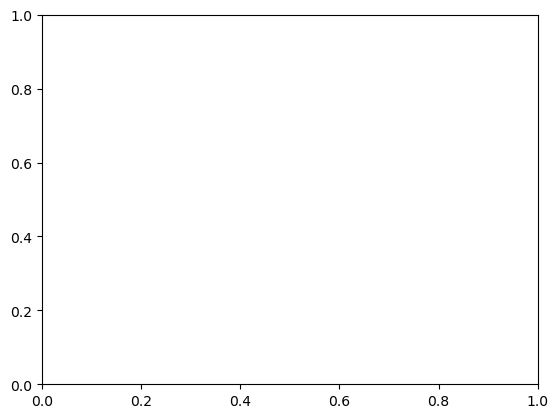

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(20), acc)
plt.xticks(range(20))
plt.title("Training Accuracy per Epoch for Epsilon = 50")
plt.show()

In [10]:
from opacus import PrivacyEngine
runs = []
trun = []
for i in [0.2, 0.3, 0.5, 1, 2]:
    model = DP_GSD()

    from opacus.validators import ModuleValidator

    model = ModuleValidator.fix(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    
    privacy_engine = PrivacyEngine(accountant = 'rdp_plrv')
    
    optimizer = optim.RMSprop(model.parameters(), lr=LR)

    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier = 1,
        #epochs=EPOCHS,
        #target_epsilon=i,
        #target_delta=DELTA,
        max_grad_norm=MAX_GRAD_NORM,
    )
    
    report = []

    for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
        results = train(model, train_loader, optimizer, epoch + 1, device)
        report.append(results)
    
    runs.append(report)
    trun.append(test(model, test_loader, device))
    del model
    del optimizer

/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

/home/knil/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/knil/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 43)]
1.0000166668055563
	Train Epoch: 1 	Loss: 2.300117 Acc@1: 14.250649 (ε = 10.13, δ = 1e-05)


/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/accountants/analysis/rdp_plrv.py:127: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 89)]
1.0000166668055563
	Train Epoch: 1 	Loss: 2.298638 Acc@1: 17.052007 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 161)]
1.0000166668055563
	Train Epoch: 2 	Loss: 2.295985 Acc@1: 20.249347 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 207)]
1.0000166668055563
	Train Epoch: 2 	Loss: 2.295637 Acc@1: 20.980414 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 280)]
1.0000166668055563
	Train Epoch: 3 	Loss: 2.293646 Acc@1: 25.295044 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.66666666666

Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 47)]
1.0000166668055563
	Train Epoch: 1 	Loss: 2.301136 Acc@1: 11.517125 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 92)]
1.0000166668055563
	Train Epoch: 1 	Loss: 2.300275 Acc@1: 12.556237 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 163)]
1.0000166668055563
	Train Epoch: 2 	Loss: 2.297464 Acc@1: 20.396137 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.6666666666666667e-05, 'max_grad_norm': 2}, 207)]
1.0000166668055563
	Train Epoch: 2 	Loss: 2.296586 Acc@1: 21.492815 (ε = 10.13, δ = 1e-05)
[({'moment': 1, 'theta': 2, 'k': 0, 'mu': 0, 'sigma': 0, 'a': 0, 'b': 0, 'epsilon': 1.666666666666

KeyboardInterrupt: 

In [ ]:
report

In [ ]:
labels = [0.2, 0.3, 0.5, 1, 2]
for j in range(len(runs)):
    acc = []
    e = []
    for i in runs[j]:
        acc.append(i[0])
        e.append(i[1])
    
    plt.plot(range(10), e, label=labels[j])
    
plt.legend(loc="lower right")
plt.xticks(range(10))
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
plt.title("Training Accuracy per Epoch for different values of Maximum Epsilon")
plt.show()

In [ ]:
x = [0.2, 0.3, 0.5, 1, 2]
y=[]
for i in runs:
    y.append(i[-1][0])

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Epsilon")
plt.plot(x, trun, 'ro-', label="Testing Acc")
plt.legend(loc="lower right")
plt.show()

In [ ]:
runs = []
trun = []

for i in [0.2, 0.3, 0.5, 1, 2]:
    model = DP_GSD()

    from .opacus.validators import ModuleValidator

    model = ModuleValidator.fix(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    
    privacy_engine = PrivacyEngine()
    
    optimizer = optim.RMSprop(model.parameters(), lr=LR)

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=i,
        target_epsilon=2,
        target_delta=DELTA,
        max_grad_norm=MAX_GRAD_NORM,
    )
    
    report = []

    for epoch in tqdm(range(i), desc="Epoch", unit="epoch"):
        results = train(model, train_loader, optimizer, epoch + 1, device)
        report.append(results)
    
    runs.append(report)
    trun.append(test(model, test_loader, device))
    del model

In [ ]:
x = [0.2, 0.3, 0.5, 1, 2]
y=[]
for i in runs:
    y.append(i[-1][0])

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Epochs with Epsilon = 2")
plt.plot(x, y, 'bo-', label="Training Acc")
plt.plot(x, trun, 'ro-', label="Testing Acc")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import torch